# FloPy

### Zonbud Example 1

This notebook demonstrates how to use the functions included in the zonbud utility to extract budget information from the cell by cell budget file using an array of zones.

First set the path and import the required packages. The flopy path doesn't have to be set if you install flopy from a binary installer. If you want to run this notebook, you have to set the path to your own flopy path.

In [1]:
%matplotlib inline
import os
import platform
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from flopy.utils import ZoneBudget, CellBudgetFile

# Set path to example datafiles
zbudpath = os.path.join('..', 'data', 'zonbud_examples')

# Create CellBudgetFile object
cbc_file = os.path.join(zbudpath, 'freyberg.gitcbc')
cbc_obj = CellBudgetFile(cbc_file)

nlay, nrow, ncol = cbc_obj.nlay, cbc_obj.nrow, cbc_obj.ncol

### Make Some Zones

We create a simple numpy integer-array to define some zones for which we are interested in getting cell-by-cell budget information.

array([1, 2, 3, 4])

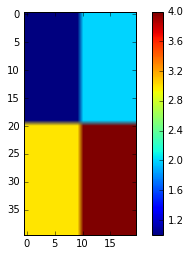

In [2]:
# Define some very interesting zones
zon = np.zeros((nlay, nrow, ncol), np.int32)
zon[0, :20, :10] = 1
zon[0, :20, 10:] = 2
zon[0, 20:, :10] = 3
zon[0, 20:, 10:] = 4

im = plt.imshow(zon[0, :, :], )
cbar = plt.colorbar(im)
np.unique(zon)

### Extract Budget Information from ZoneBudget Object

At the core of the ZoneBudget object is a numpy structured array (aka recarray). The ZoneBudget class provides some wrapper functions to help us interogate the array and save it to disk.

In [3]:
# Create a ZoneBudget object and get the budget record array
bud = ZoneBudget(cbc_obj, zon, kstpkper=(0, 0))
bud.get_records()

array([('IN', 'CONSTANT HEAD', 0.0, 0.0, 0.0, 0.0),
       ('IN', 'WELLS', 0.0, 0.0, 0.0, 0.0),
       ('IN', 'RIVER LEAKAGE', 0.0, 0.004194190260022879, 0.0, 0.0),
       ('IN', 'RECHARGE', 0.015300000726711005, 0.020000000949949026, 0.015900000755209476, 0.01830000086920336),
       ('IN', 'FROM ZONE 1', 0.0, 0.013101870194077492, 0.0028348490595817566, 0.0),
       ('IN', 'FROM ZONE 2', 0.0, 0.0, 0.0, 0.0012257143389433622),
       ('IN', 'FROM ZONE 3', 0.0006367169553413987, 0.0, 0.0, 0.013000613078474998),
       ('IN', 'FROM ZONE 4', 0.0, 0.0011461640242487192, 0.0, 0.0),
       ('OUT', 'CONSTANT HEAD', 0.0, 0.0, 0.003547519678249955, 0.0011877617798745632),
       ('OUT', 'WELLS', 0.0, 0.01619999995455146, 0.0015499999863095582, 0.00430000014603138),
       ('OUT', 'RIVER LEAKAGE', 0.0, 0.02101684292574646, 0.0, 0.025892717123497277),
       ('OUT', 'RECHARGE', 0.0, 0.0, 0.0, 0.0),
       ('OUT', 'TO ZONE 1', 0.0, 0.0, 0.0006367169553413987, 0.0),
       ('OUT', 'TO ZONE 2', 0.0

In [4]:
# Pass a list of (flow_dir, record name) tuples and/or zones to get a subset of the entire budget
recordlist = [('IN', 'RECHARGE'),
              ('IN', 'FROM ZONE 1'),
              ('IN', 'FROM ZONE 3')]
zonelist = [1, 3]
bud.get_records(recordlist=recordlist, zones=zonelist)

array([('IN', 'RECHARGE', 0.015300000726711005, 0.015900000755209476),
       ('IN', 'FROM ZONE 1', 0.0, 0.0028348490595817566),
       ('IN', 'FROM ZONE 3', 0.0006367169553413987, 0.0)], 
      dtype=[('flow_dir', 'S3'), ('record', 'S50'), ('ZONE 1', '<f8'), ('ZONE 3', '<f8')])

In [5]:
# Look at all of the mass-balance records
bud.get_mass_balance()

array([ ('INFLOW', 0.015936717682052404, 0.038442225428298116, 0.018734849814791232, 0.03252632828662172),
       ('OUTFLOW', 0.01593671925365925, 0.03844255721924128, 0.01873484969837591, 0.03252664307365194),
       ('ERROR', -9.861546138457127e-06, -0.00086308611857667, 6.213838025897463e-07, -0.0009677867855618503)], 
      dtype=[('record', 'S7'), ('ZONE 1', '<f8'), ('ZONE 2', '<f8'), ('ZONE 3', '<f8'), ('ZONE 4', '<f8')])

In [6]:
# Look at the mass-balance for just zones 1 and 3
bud.get_mass_balance(zones=[1, 3])

array([('INFLOW', 0.015936717682052404, 0.018734849814791232),
       ('OUTFLOW', 0.01593671925365925, 0.01873484969837591),
       ('ERROR', -9.861546138457127e-06, 6.213838025897463e-07)], 
      dtype=[('record', 'S7'), ('ZONE 1', '<f8'), ('ZONE 3', '<f8')])

In [7]:
# Look at just the percent error record
bud.get_percent_error()

array([ -9.86154614e-06,  -8.63086119e-04,   6.21383803e-07,
        -9.67786786e-04])

In [8]:
# Look at the total inflow for zones 1 and 3
bud.get_total_inflow(zones=[1, 3])

array([ 0.01593672,  0.01873485])

### Easily Convert Units
The ZoneBudget class provides methods for using mathematical operators and returns a new copy of the object.

In [9]:
cfd = ZoneBudget(cbc_obj, zon, kstpkper=(0, 0))
print('cubic feet/day', cfd.recordarray[6]['ZONE 1'])

mgd = cfd*(7.48052/1000000)
print('million gallons/day', mgd.recordarray[6]['ZONE 1'])

('cubic feet/day', 0.00063671695534139872)
('million gallons/day', 4.7629739187704405e-09)


### Alias Names
A dictionary of {zone, 'alias'} pairs can be passed to replace the typical 'ZONE X' fieldnames of the ZoneBudget structured array.

In [10]:
aliases = {1: 'Surficial aquifer', 2:'Confining Unit', 3: 'Upper Floridan aquifer', 4: 'Offshore GHB'}
cfd = ZoneBudget(cbc_obj, zon, kstpkper=(0, 0), aliases=aliases)
cfd.get_records()

array([('IN', 'CONSTANT HEAD', 0.0, 0.0, 0.0, 0.0),
       ('IN', 'WELLS', 0.0, 0.0, 0.0, 0.0),
       ('IN', 'RIVER LEAKAGE', 0.0, 0.004194190260022879, 0.0, 0.0),
       ('IN', 'RECHARGE', 0.015300000726711005, 0.020000000949949026, 0.015900000755209476, 0.01830000086920336),
       ('IN', 'FROM Surficial aquifer', 0.0, 0.013101870194077492, 0.0028348490595817566, 0.0),
       ('IN', 'FROM Confining Unit', 0.0, 0.0, 0.0, 0.0012257143389433622),
       ('IN', 'FROM Upper Floridan aquifer', 0.0006367169553413987, 0.0, 0.0, 0.013000613078474998),
       ('IN', 'FROM Offshore GHB', 0.0, 0.0011461640242487192, 0.0, 0.0),
       ('OUT', 'CONSTANT HEAD', 0.0, 0.0, 0.003547519678249955, 0.0011877617798745632),
       ('OUT', 'WELLS', 0.0, 0.01619999995455146, 0.0015499999863095582, 0.00430000014603138),
       ('OUT', 'RIVER LEAKAGE', 0.0, 0.02101684292574646, 0.0, 0.025892717123497277),
       ('OUT', 'RECHARGE', 0.0, 0.0, 0.0, 0.0),
       ('OUT', 'TO Surficial aquifer', 0.0, 0.0, 0.000636

In [11]:
# View the budget as a Pandas DataFrame
aliases = {1: 'Surficial aquifer', 2:'Confining Unit', 3: 'Upper Floridan aquifer', 4: 'Offshore GHB'}
mgd = ZoneBudget(cbc_obj, zon, kstpkper=(0, 0), aliases=aliases)*(7.4808/1000000)
df = pd.DataFrame(mgd.get_records())
df = df.set_index(['flow_dir', 'record']).sort_index()  # sort multi-index so we can slice it later
df

Surficial aquifer  Confining Unit  \
flow_dir record                                                           
IN       CONSTANT HEAD                     0.000000e+00    0.000000e+00   
         FROM Confining Unit               0.000000e+00    0.000000e+00   
         FROM Offshore GHB                 0.000000e+00    8.574224e-09   
         FROM Surficial aquifer            0.000000e+00    9.801247e-08   
         FROM Upper Floridan aquifer       4.763152e-09    0.000000e+00   
         RECHARGE                          1.144562e-07    1.496160e-07   
         RIVER LEAKAGE                     0.000000e+00    3.137590e-08   
         WELLS                             0.000000e+00    0.000000e+00   
OUT      CONSTANT HEAD                     0.000000e+00    0.000000e+00   
         RECHARGE                          0.000000e+00    0.000000e+00   
         RIVER LEAKAGE                     0.000000e+00    1.572228e-07   
         TO Confining Unit                 9.801247e-08    0.000000e+00   
         TO Offshore GHB                   0.000000e+00    9.169324e-09   
         TO Surficial aquifer              0.000000e+00    0.000000e+00   
         TO Upper Floridan aquifer         2.120694e-08    0.000000e+00   
         WELLS                             0.000000e+00    1.211890e-07   

                                      Upper Floridan aquifer  Offshore GHB  
flow_dir record                                                             
IN       CONSTANT HEAD                          0.000000e+00  0.000000e+00  
         FROM Confining Unit                    0.000000e+00  9.169324e-09  
         FROM Offshore GHB                      0.000000e+00  0.000000e+00  
         FROM Surficial aquifer                 2.120694e-08  0.000000e+00  
         FROM Upper Floridan aquifer            0.000000e+00  9.725499e-08  
         RECHARGE                               1.189447e-07  1.368986e-07  
         RIVER LEAKAGE                          0.000000e+00  0.000000e+00  
         WELLS                                  0.000000e+00  0.000000e+00  
OUT      CONSTANT HEAD                          2.653829e-08  8.885408e-09  
         RECHARGE                               0.000000e+00  0.000000e+00  
         RIVER LEAKAGE                          0.000000e+00  1.936982e-07  
         TO Confining Unit                      0.000000e+00  8.574224e-09  
         TO Offshore GHB                        9.725499e-08  0.000000e+00  
         TO Surficial aquifer                   4.763152e-09  0.000000e+00  
         TO Upper Floridan aquifer              0.000000e+00  0.000000e+00  
         WELLS                                  1.159524e-08  3.216744e-08

In [12]:
# Look at recharge to the surficial and Upper Floridan aquifers
df.loc[(['IN'], ['RECHARGE']), ['Surficial aquifer', 'Upper Floridan aquifer']].sum(axis=1)  # axis=1 to sum along rows

flow_dir  record  
IN        RECHARGE    2.334010e-07
dtype: float64

In [13]:
# Look at all outflow to offshore general head boundaries
df.loc[(['OUT'], slice(None)), 'Offshore GHB'].sum()

2.4332531150537546e-07

### Write Budget Output to CSV

We can write the resulting recarray to a csv with the .to_csv() method of the Budget object.

In [14]:
cfd = ZoneBudget(cbc_obj, zon, kstpkper=(0, 0), aliases=aliases)
cfd.to_csv(os.path.join(zbudpath, 'zbud_zonbud.csv'), write_format='zonbud')
cfd.to_csv(os.path.join(zbudpath, 'zbud_pandas.csv'), write_format='pandas')

# Read the file in to see the contents
fname = os.path.join(zbudpath, 'zbud_zonbud.csv')
try:
    import pandas as pd
    df = pd.read_csv(fname)
    print(df.to_string(index=True))
except:
    with open(fname, 'r') as f:
        for line in f.readlines():
            print('\t'.join(line.split(',')))

                                           Time Step                        1           Stress Period                      1.1
                                   Surficial aquifer           Confining Unit  Upper Floridan aquifer             Offshore GHB
                                                  IN                       IN                      IN                       IN
CONSTANT HEAD                 0.0000000000000000e+00   0.0000000000000000e+00  0.0000000000000000e+00   0.0000000000000000e+00
WELLS                         0.0000000000000000e+00   0.0000000000000000e+00  0.0000000000000000e+00   0.0000000000000000e+00
RIVER LEAKAGE                 0.0000000000000000e+00   4.1941902600228786e-03  0.0000000000000000e+00   0.0000000000000000e+00
RECHARGE                      1.5300000726711005e-02   2.0000000949949026e-02  1.5900000755209476e-02   1.8300000869203359e-02
FROM Surficial aquifer        0.0000000000000000e+00   1.3101870194077492e-02  2.8348490595817566e-03   0.00000